# TITLE

# Introduction

To fill

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data Exploration and Processing
- **Part 2 :** Data Analysis
- **Part 3 :** Is LDA a feasible method for our data ?

</div></div>
<br/>

---

# Part 1: Data Exploration and Processing

### Import libraries

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import ast
# LDA
# gensim is a popular library for topic modelling
# nltk.download('punkt')
# nltk.download('stopwords')
#from gensim.corpora import Dictionary
#from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imdb import IMDb
import nltk
import re
import kagglehub # To extract synopsis dataframes
#import spacy




## 1.1 Dataset exploration 

### Load initial movie dataset

In [33]:
movie_columnns =['Wikipedia movie ID','Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movie = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movie_columnns)
movie.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


# COMMENT WHAT IS THE FEATURE COMPOSTION 

We start by exploring the dataset length and type of features

In [95]:
movie.shape
print('The dataset contains', movie.shape[0], 'and',movie.shape[1] , 'features for each.')

The dataset contains 81741 and 9 features for each.


In [99]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wikipedia movie ID        81741 non-null  int64  
 1   Freebase movie ID         81741 non-null  object 
 2   Movie name                81741 non-null  object 
 3   Movie release date        74839 non-null  object 
 4   Movie box office revenue  8401 non-null   float64
 5   Movie runtime             61291 non-null  float64
 6   Movie languages           81741 non-null  object 
 7   Movie countries           81741 non-null  object 
 8   Movie genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


# QUICK COMMENT ABOUT THE TYPE

We decide to remove the Freebase movie ID as it is no longer actively used and since for our analysis we are not interested in the movie runtime we drop this column too. 

In [36]:
movie_drop = movie.drop(['Freebase movie ID', 'Movie runtime'], axis=1)
movie_drop.head()


,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres
0,975900,Ghosts of Mars,2001-08-24,14010832.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,1988,NaN,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,1987,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,1983,NaN,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## CHNAGE COMMENT

The three following column of our dataset: Movie languages,	Movie countries and Movie genres are formatted differently

In [37]:
def convert_to_list(df, column_name):
    #Convert to dictionnary 
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    #Convert to list
    df[column_name] = df[column_name].apply(lambda x: list(x.values()) if isinstance(x, dict) else None)
    return df[column_name]

In [38]:
movies_df = movie_drop.copy()
movies_df['Movie genres'] = convert_to_list(movies_df, 'Movie genres')
movies_df['Movie languages'] = convert_to_list(movies_df, 'Movie languages')
movies_df['Movie countries'] = convert_to_list(movies_df, 'Movie countries')

In [39]:
movies_df.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres
0,975900,Ghosts of Mars,2001-08-24,14010832.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,Brun bitter,1988,NaN,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,White Of The Eye,1987,NaN,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,A Woman in Flames,1983,NaN,[German Language],[Germany],[Drama]


We can now see that the columns containing information about movie languages, countries, and genres are indeed formatted as lists. 

For our analysis, having the full release date isn't necessary, just the year is enough. Therefore, we convert the release date into a year format (e.g. 1995-07-21 becomes 1995).

In [40]:
def extract_year(value):
    # Check if the value is a year (4-digit number) and return it as is
    if isinstance(value, int) or (isinstance(value, str) and value.isdigit() and len(value) == 4):
        return int(value)
    # Try to convert complete date strings to datetime and extract the year
    try:
        return pd.to_datetime(value).year
    except (ValueError, TypeError):
        return np.nan  # Return NaN if conversion fails

movies_df['Movie release date'] = movies_df['Movie release date'].apply(extract_year).astype('Int64')

print(movies_df['Movie release date'].head())

0    2001
1    2000
2    1988
3    1987
4    1983
Name: Movie release date, dtype: Int64


## EXPLAIN WHY INTERSTED ON SUMMARY (LDA)

In [41]:
sum_columns = ['Wikipedia movie ID','Plot summary']
sum_df = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None)
sum_df.columns = sum_columns

In [42]:
# Length of each plot summary
sum_df['summary_length'] = sum_df['Plot summary'].apply(len)
sum_df['summary_length'].describe()

count    42303.000000
mean      1784.034229
std       1808.925536
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64

# SAY SOMETHING LIKE TOO SMALL AND INCOMPLETE FRO WHAT ANALYSIS WE WWANT TO DO so we chose synopsis

+ small explanation about the dataset 

In [43]:
# Load data
synopsis = pd.read_csv('Data/mpst_full_data.csv')

# Check data shape
print("This synopsis dataframe is of size:", synopsis.shape)

# Display df
synopsis.head()

This synopsis dataframe is of size: (14828, 6)


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [44]:
# Length of each plot summary
size_synopsis = synopsis.copy()
size_synopsis['plot_length'] = synopsis['plot_synopsis'].apply(len)
size_synopsis['plot_length'].describe()

count    14828.000000
mean      5139.938090
std       4939.950638
min        442.000000
25%       2494.750000
50%       3827.000000
75%       5760.000000
max      63959.000000
Name: plot_length, dtype: float64

### Comment
The dataframe offers extra movie tags and the full movie synopsis which would give the LDA more context to group movies together. On the other hand there a only 14'828 rows which is consequently smaller than the initial dataframe. We make the choice to reduce the dataset but gain precision on the themes generated by the LDA. Another important notice is that this dataframe uses imdb_id not wikipedia movie ids.

# ALSO COMPARE TO MOVIE SUMMARY LENGTH 

In this dataset there is also column that we are not interested about so we drop them.

In [45]:
movies_syn = synopsis.merge(movies_df, left_on='title', right_on='Movie name', how='inner')
movies_syn.drop(columns=['title', 'split', 'synopsis_source'], inplace=True)
movies_syn.head()

,imdb_id,plot_synopsis,tags,synopsis_source,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012,NaN,[],[United Kingdom],[Fantasy]
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb,76353,The Shop Around the Corner,1940,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-..."
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb,171076,Mr. Holland's Opus,1995,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi..."
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,76331,Scarface,1932,NaN,"[Italian Language, English Language]",[United States of America],"[Crime Fiction, Gangster Film, Black-and-white..."
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,267848,Scarface,1983,65884703.0,"[English Language, Spanish Language]",[United States of America],"[Crime Fiction, Thriller, Gangster Film, Actio..."


In [46]:
lost_rows = synopsis.shape[0] - movies_syn.shape[0]
print(f"We only lost {lost_rows} movies by merging the two dataset by the titles of the movies.")

We only lost 94 movies by merging the two dataset by the titles of the movies.


### Comment

1. Movie loss


The size fo the dataframe has not significantly changed, only 94 movies did not match. Our original movie df contained most of the movies present in the synopsis df.

2. Same title


We also observe that Scarface appears twice since there was a remake. For the rest for the analysis we will assume that if the name of the movie is exactly the same, the synopsis is pretty similar for both movies (if not the same!).

# COMMENT FOR ANALYSSIS ALSO INTERESTED IN RATINGS
We found a IMDB dataset online. 

In [47]:
ratings_df = pd.read_csv('data/title.ratings.tsv', sep='\t')
ratings_df = ratings_df.rename(columns={'tconst': 'imdb_id'})

We rename the column to match the name our dataset

In [48]:
movies_ratings = pd.merge(movies_syn,ratings_df,on='imdb_id',how='inner')
movies_ratings.head()

,imdb_id,plot_synopsis,tags,synopsis_source,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres,averageRating,numVotes
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012,NaN,[],[United Kingdom],[Fantasy],4.4,2722
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb,76353,The Shop Around the Corner,1940,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39420
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb,171076,Mr. Holland's Opus,1995,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42244
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,76331,Scarface,1932,NaN,"[Italian Language, English Language]",[United States of America],"[Crime Fiction, Gangster Film, Black-and-white...",8.3,939605
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,267848,Scarface,1983,65884703.0,"[English Language, Spanish Language]",[United States of America],"[Crime Fiction, Thriller, Gangster Film, Actio...",8.3,939605


Our dataset is now complete for the analysis, however we need to check the NaN values before

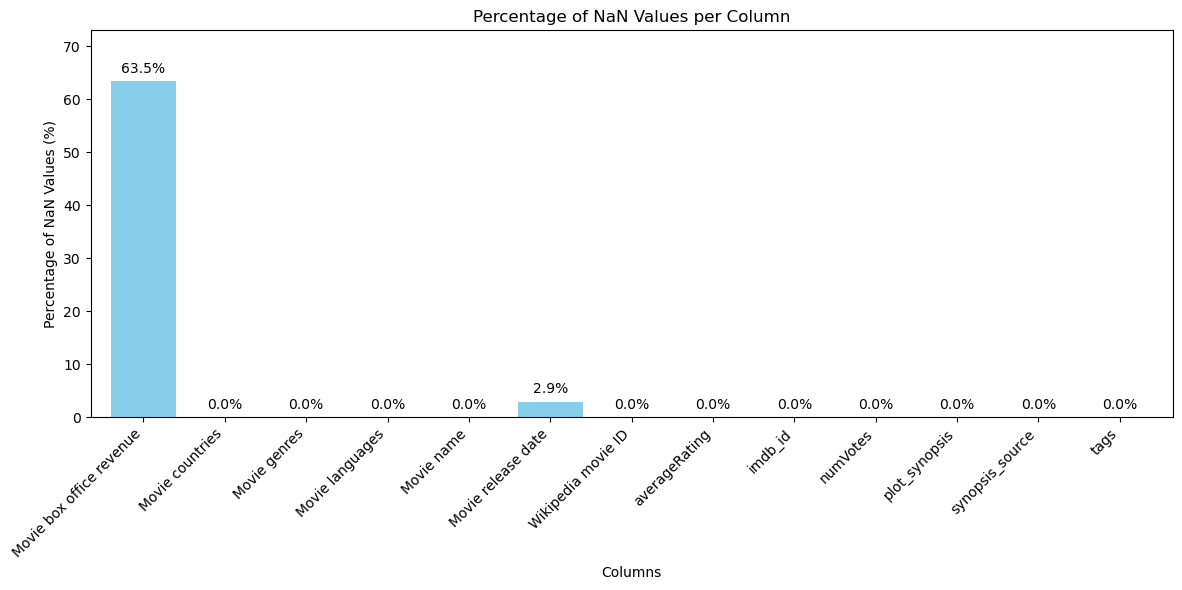

In [49]:
# Calculate percentage of NaN values in each column
na_percentage = (movies_ratings.isna().sum() / len(movies_ratings)) * 100
na_percentage = na_percentage.sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = na_percentage.plot(kind='bar', color='skyblue', width=0.8)  

# Add percentage labels on top of each bar
for i, value in enumerate(na_percentage):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)  

plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')  
plt.ylabel('Percentage of NaN Values (%)')
plt.ylim(top =73)
plt.title('Percentage of NaN Values per Column')
plt.tight_layout()  

plt.show()


Two columns contain NaN values. We need to handle. BETTER COMMENT

We remove the years that are NaN as we are intereseted in the release years

In [52]:
print(movies_ratings['Movie release date'].isna().value_counts())
movies_df_cleaned = movies_ratings.dropna(subset=['Movie release date'])

movies_df_cleaned['Movie release date'].isna().any()

False    14253
True       433
Name: Movie release date, dtype: int64


False

After realizing the high number of NaN values in the box-office revenue column, we decided to complete this data as much as possible with the IMDB library.

In [ ]:
def clean_ids(s, pattern=' '): #remove in string a pattern
    s = str(s).replace(pattern, '')
    return s

#Get the right imdb_id by removing 'tt' in front of IDs
movies_df_cleaned['imdb_id'] = movies_df_cleaned['imdb_id'].apply(lambda x : clean_ids(x, 'tt'))

#Create a dic telling if 'Movie box office revenue' is a NaN or not
isnan_dic = movies_df_cleaned['Movie box office revenue'].isna()

def get_box_office(imdb_ID): #return the box-office revenue for a specific imdb_id
    ia = IMDb()
    movie = ia.get_movie(imdb_ID)
    box_office = movie.get('box office')
    if box_office and 'Cumulative Worldwide Gross' in box_office:
        box_office_num = float(re.sub(r'[^\d.]', '', box_office['Cumulative Worldwide Gross']))
        #box_office_num = float(box_office['Cumulative Worldwide Gross'].replace('$', '').replace(',', ''))
        return box_office_num
    return None  # Return None if no box office data is found


In [ ]:
#Quick checks
index_case1 = 0
index_case2 = 1
index_case3 = 2
print(f"The initial box-office was {movies_df_cleaned.iloc[index_case1]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_df_cleaned.iloc[index_case1]['imdb_id'])}")
print(f"The initial box-office was {movies_df_cleaned.iloc[index_case2]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_df_cleaned.iloc[index_case2]['imdb_id'])}")
print(f"The initial box-office was {movies_df_cleaned.iloc[index_case3]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_df_cleaned.iloc[index_case3]['imdb_id'])}")

We are indeed getting more box-office data, and recovering the same value in cases where we already had data ! Let's now apply the function on the whole dataset.

In [ ]:
#Apply on the whole dataset
run = False #Run is very long, directly use the file in Data directory
if run:
    box_offices = movies_df_cleaned.apply(lambda x: get_box_office(x['imdb_id']) if isnan_dic[x.name] else x['Movie box office revenue'], axis=1) #Try to get the box-office from Imdb only if we don't already have it
    movies_df_cleaned.insert(len(movies_df_cleaned.columns), 'IMDB Box-office', box_offices)

In [ ]:
movies_synopsis_comp = movies_df_cleaned.copy()

In [ ]:
#Here is the file with completed box-office from Imdb (last column)
movies_synopsis_comp = pd.read_csv('Data/movies_synopsis_comp.csv')
display(movies_synopsis_comp.head())

### Comment

We completed some of the missing data, but how much did we improve ?

In [ ]:
#Improvement in NaN values in box-office
na_percentage_box_init = (movies_synopsis_comp['Movie box office revenue'].isna().sum() / len(movies_synopsis_comp)) * 100
na_percentage_box_imdb = (movies_synopsis_comp['IMDB Box-office'].isna().sum() / len(movies_synopsis_comp)) * 100
print(f"We went from {round(na_percentage_box_init,2)}% of NaN values to {round(na_percentage_box_imdb,2)}%.")

In [ ]:
#Remove the old revenue column as we don't need it anymore
movies_synopsis_comp.drop('Movie box office revenue', axis=1, inplace=True)

### Comment
The increase is a bit deceiving. The IMDB library is missing a lot of box-offices too. We suspect the IMDB library to mabe block when there are too many requests, giving more NaN values than there actually are. In the end that's still an increase of 24% in box-office data size, which will help us for our analysis.

## COMMENT HOW HANDLE MISSING VALUES

# PART 2: Data Analysis

### A CHANGER AVEC movie_final = movies_synopsis_comp.copy() MAIS J'AVAIS PAS LE DATASET

In [53]:
movie_final = movies_df_cleaned.copy()

### Movies' genres exploration

In [58]:
all_genres = movie_final['Movie genres'].explode()

genres_counts = all_genres.value_counts()

num_unique_genre = all_genres.nunique()
print("Number of unique genres:", num_unique_genre)

Number of unique genres: 333


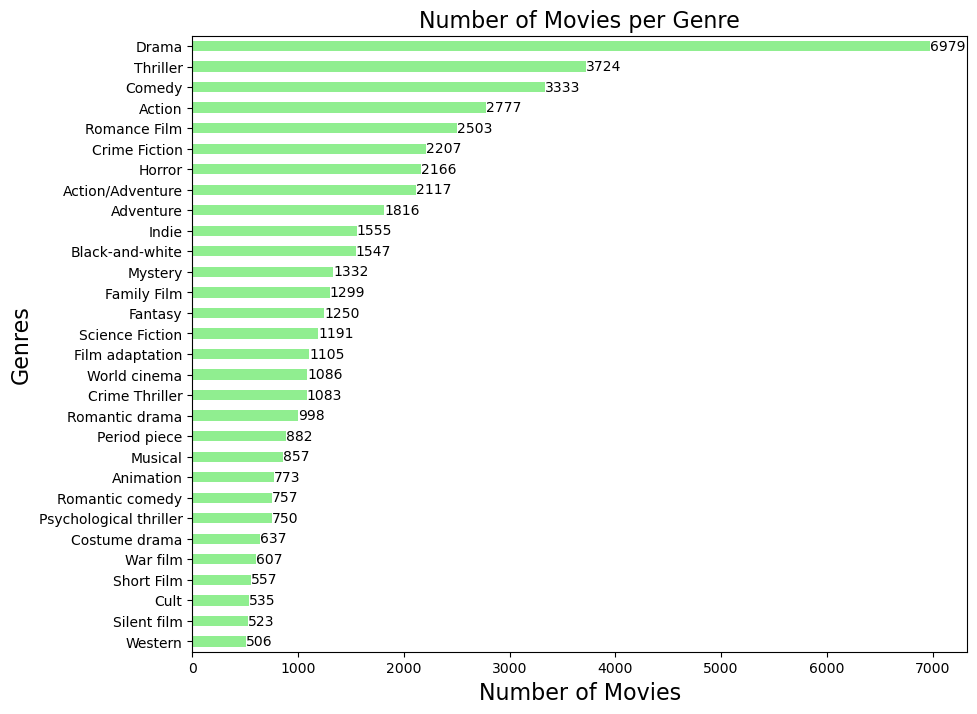

In [59]:
# Plot the number of movies per top 30 genres
plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen')

for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)  

plt.show()

Drama is the clear leader when it comes to movie genres, followed by Comedy and Romance. This makes sense since these genres appeal to a wide range of audiences. Genres like Thriller, Action, and Documentary are also popular, showing that people enjoy excitement and real-life stories. On the other end, niche genres like 'Cult' and 'Political drama' are much less common, which isn't surprising given their more specific audience.

Here we decided to show only the top 30 genres to keep the chart clear and easy to read.

### Movies Box office exploration

In [60]:
# Faire plot 

### Movies Ratings exploration

In [101]:
movie_final['averageRating'].describe()

count    14253.000000
mean         6.378678
std          1.072964
min          1.300000
25%          5.800000
50%          6.500000
75%          7.100000
max          9.300000
Name: averageRating, dtype: float64

## QUICK COMMENT

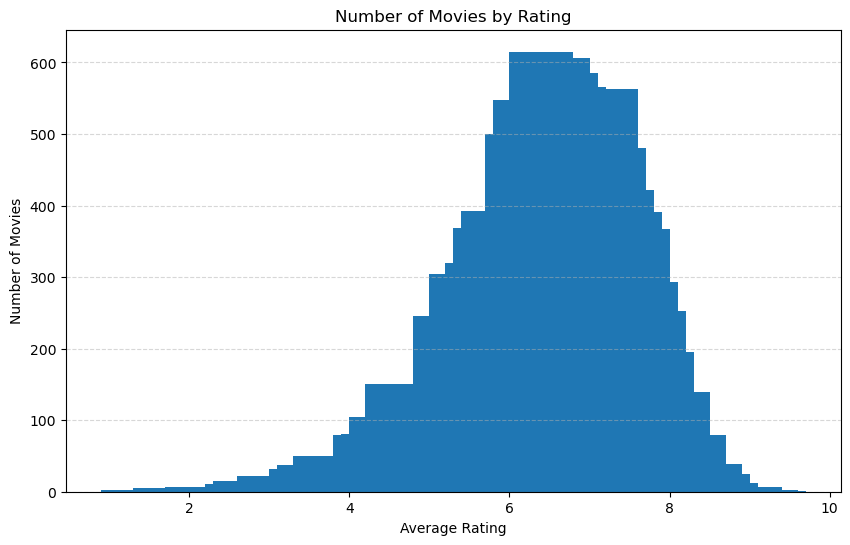

In [100]:
rating_counts = movie_final['averageRating'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## COMMENTer + faire un plot plus joli ??

### Movies countries exploration

In [62]:
all_countries = movie_final['Movie countries'].explode()

countries_counts = all_countries.value_counts() 

print(countries_counts)

United States of America    10205
United Kingdom               2268
France                        757
Germany                       650
India                         647
                            ...  
Mandatory Palestine             1
Kenya                           1
Sri Lanka                       1
Serbia and Montenegro           1
Mongolia                        1
Name: Movie countries, Length: 109, dtype: int64


In [63]:
num_unique_countries = all_countries.nunique()
print("Number of unique countries:", num_unique_countries)

Number of unique countries: 109


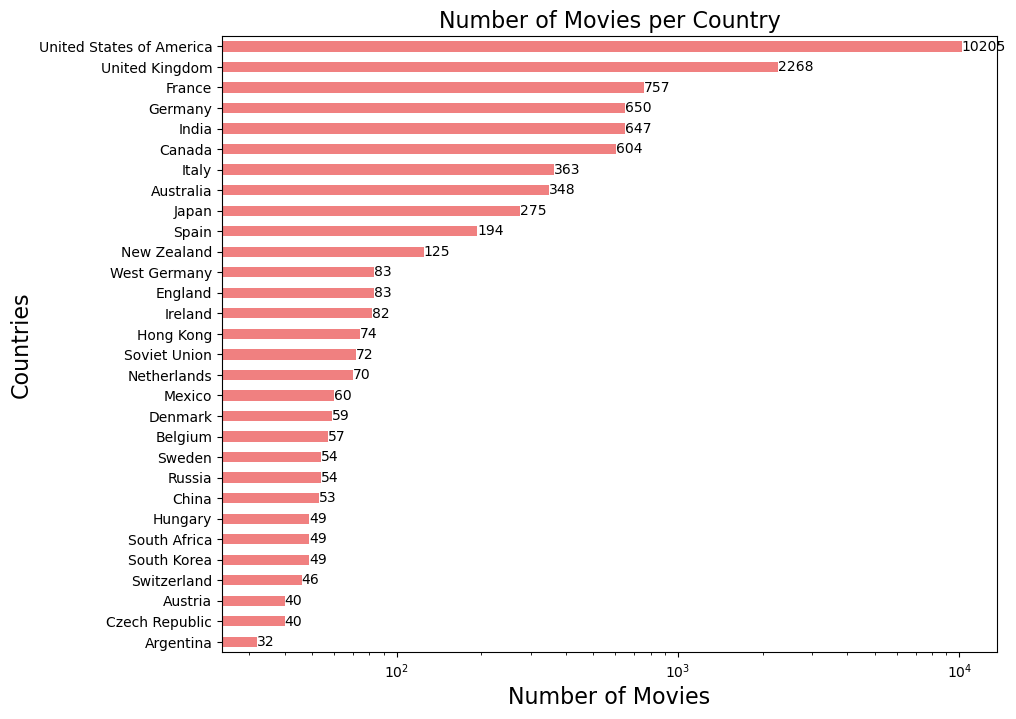

In [102]:
# Plot the number of movies per top 30 country
plt.figure(figsize=(10, 8))
bars = countries_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightcoral')

for index, value in enumerate(countries_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Countries', fontsize=16)
plt.title('Number of Movies per Country', fontsize=16)  
plt.xscale('log')
plt.show()

The United States has the most movies by far, showing its huge impact on the film industry. The United Kingdoms and France come next, thanks to Bollywood and British cinema. Germany, India and Canada also produce a lot of movies. The numbers drop as you go down the list, with fewer movies made in other countries.

We decided to show only the top 30 countries to keep the chart clear and easy to read. For better readibility we used a log scale on the x axis.

### Movies languages exploration

In [54]:
all_languages = movie_final['Movie languages'].explode()

language_counts = all_languages.value_counts()

print(language_counts)

English Language           11712
French Language              755
Spanish Language             531
Hindi Language               505
German Language              414
                           ...  
Hmong language                 1
Azerbaijani language           1
Malay Language                 1
Farsi, Western Language        1
Southwestern Mandarin          1
Name: Movie languages, Length: 148, dtype: int64


In [55]:
num_unique_languages = all_languages.nunique()
print("The dataset contains ", num_unique_languages, "unique languages.")

The dataset contains  148 unique languages.


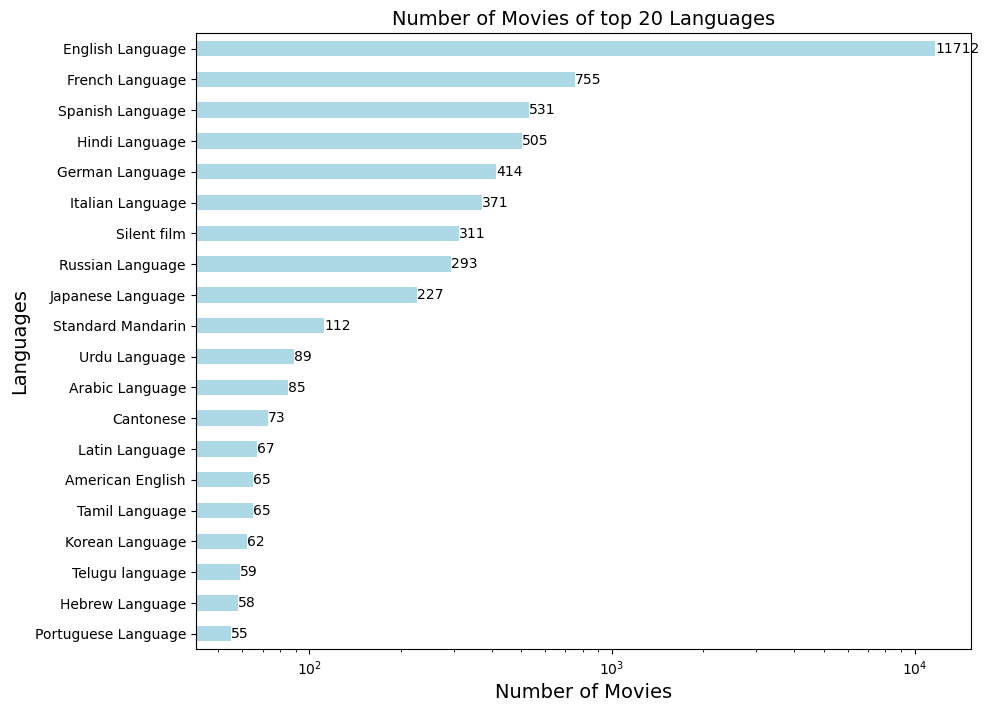

In [103]:
# Plot the number of movies per language 
plt.figure(figsize=(10, 8))
bars = language_counts.head(20).sort_values(ascending=True).plot(kind='barh', color='lightblue')

for index, value in enumerate(language_counts.head(20).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies',fontsize=14)
plt.ylabel('Languages',fontsize=14)
plt.title('Number of Movies of top 20 Languages', fontsize=14)
plt.xscale('log')
plt.show()

As previously seen, English is largely dominant. This can be attributed to its role as a global lingua franca, making films more accessible to international audiences. Additionally, major movie industries in countries like the United Kingdom and other English-speaking regions contribute to the high number of English-language films.

For better visibility, we chose to display only the top 20 languages in this chart. It is also noticeable that the number of movies per language drops off quickly after the most common languages, highlighting the dominance of a few major languages in movie production and a long tail of less commonly represented languages. For better readibility we used a log scale on the x axis.

### Movies release year exploration

Here we do a general analysis about the total number of movies released each year.

In [65]:
all_years = movie_final['Movie release date'].explode()
years_counts = all_years.value_counts()

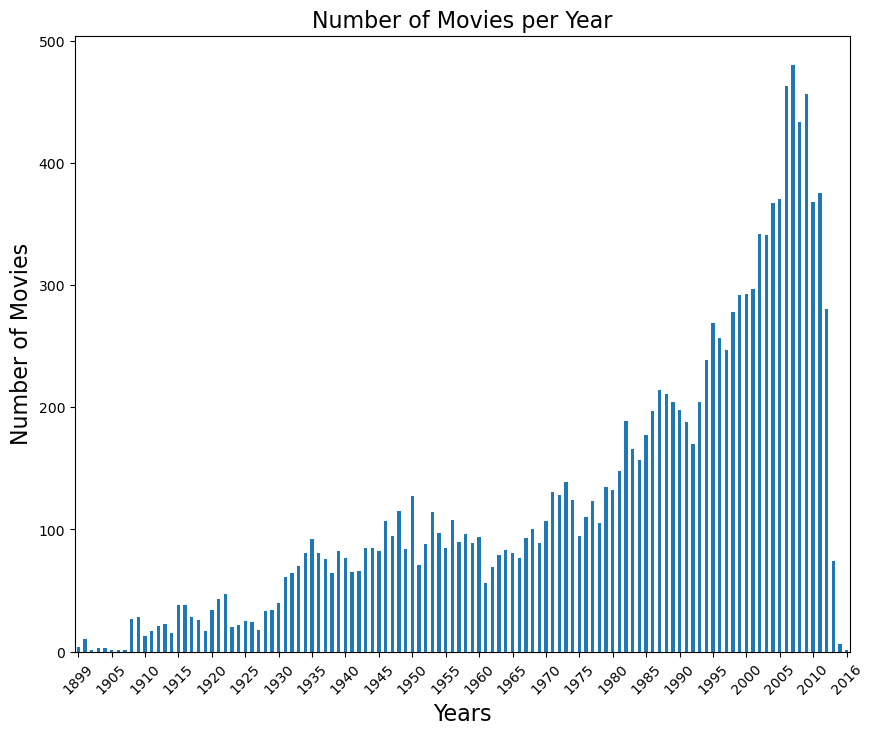

In [66]:
plt.figure(figsize=(10, 8))  
plot_years_counts = all_years.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Years', fontsize=16 )
plt.ylabel('Number of Movies', fontsize=16)
plt.title('Number of Movies per Year', fontsize=16)

plt.xticks(range(0, len(all_years.value_counts().sort_index()), 5), 
           all_years.value_counts().sort_index().index[::5], 
           rotation=45)

plt.show()

The movie production has grown steadily over time, with a big jump starting in the 1990s and peaking in the early 2000s. The increase after the 1980s is likely due to better technology and more people making movies around the world. The early years have fewer movies because the film industry was just getting started.

### Movies per decade for most important countries

In [75]:
# Get top 10 countries releasing movies
top_10_countries = countries_counts.head(10).index

# Get one country per row (since some movies contain more that one countries)
expanded_df = movie_final.explode('Movie countries')

top_countries_df = expanded_df[expanded_df['Movie countries'].isin(top_10_countries)]

In [79]:
top_countries_df['Decade'] = (top_countries_df['Movie release date'] // 10) * 10

# Group by decade and country, count the number of movies
movies_per_decade_countries = top_countries_df.groupby(['Decade', 'Movie countries']).size().unstack(fill_value=0)

/var/folders/tp/ncf811k96mv0r_6b8tn9rw340000gn/T/ipykernel_29197/3397669656.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
# Create the interactive figure
fig = go.Figure()

for country in movies_per_decade_countries.columns:
    fig.add_trace(go.Bar(
        x=movies_per_decade_countries.index,  # Decades
        y=movies_per_decade_countries[country],  # Number of movies
        name=country,
        hovertemplate='Percentage: %{customdata:.2f}%',
        customdata=100 * movies_per_decade_countries[country] / movies_per_decade_countries.sum(axis=1)
    ))

fig.update_layout(
    title='Proportion of Movies Produced by Top 10 Countries per Decade',
    xaxis_title='Decade',
    yaxis_title='Number of Movies',
    barmode='stack',
    legend_title='Country',
    hovermode='x'
)

fig.show()


The U.S. consistently dominates movie production across all decades, though its share decreases over time from near-total dominance in the early 20th century to around 40-50% in the later decades. Other countries, such as India, the UK, and France, start contributing more significantly from the 1950s onward, indicating a diversification in global movie production over the decades.

### Do the genres of the released movies vary on different decades?

In [82]:
# Get top 20 genres releasing movies
top_20_genres = genres_counts.head(20).index

# Get one country per row
expanded_df_genre = movie_final.explode('Movie genres')

# the top 20
top_genres_df_20 = expanded_df_genre[expanded_df_genre['Movie genres'].isin(top_20_genres)]

movies_per_year_genres_20 = top_genres_df_20.groupby(['Movie genres', 'Movie release date']).size().unstack(fill_value=0)
movies_per_decade_genres_20 = movies_per_year_genres_20.groupby((movies_per_year_genres_20.columns // 10) * 10, axis=1).sum()

movies_per_decade_genres_20_percentage = movies_per_decade_genres_20.div(movies_per_decade_genres_20.sum(axis=1), axis=0)

We decide to keep only the top 20 genres so that our graph stay clear but you can adjust this number if needed. 

In [105]:
movies_per_decade_by_genre = movies_per_decade_genres_20.T

# Ensure your DataFrame `movies_per_decade_by_genre_normalized` is defined and normalized
movies_per_decade_by_genre_normalized = movies_per_decade_by_genre.div(movies_per_decade_by_genre.sum(axis=1), axis=0)

In [106]:
# Create an interactive figure
fig = go.Figure()

# Iterate through each decade and create a bar plot for it
for decade in movies_per_decade_by_genre_normalized.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_by_genre_normalized.columns,
        y=movies_per_decade_by_genre_normalized.loc[decade],  # Convert to percentage
        name=f'{decade}s',
        visible=False  # Initially set all traces to invisible
    ))

# Set the first decade to be visible
fig.data[0].visible = True

# Create the slider steps
steps = []
for i, decade in enumerate(movies_per_decade_by_genre_normalized.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  # Hide all traces
        label=f"{decade}s"
    )
    step["args"][0]["visible"][i] = True  # Set the current decade's trace to visible
    steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Decade: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to include the slider
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released by Genre in Each Decade',
    xaxis_title='Genre',
    yaxis_title='Percentage of Movies',
    yaxis=dict(tickformat=".1%"),
    barmode='group'
)

# Show the plot
fig.show()


## COMMENTER

In [112]:
ig = go.Figure()

for genre in movies_per_decade_genres_20_percentage.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_genres_20_percentage.columns,  # Decades
        y=movies_per_decade_genres_20_percentage.loc[genre],  # Percentage values for each decade
        name=genre,
        visible=False  
    ))

fig.data[0].visible = True

# Create the slider steps for each genre
steps = []
for i, genre in enumerate(movies_per_decade_genres_20_percentage.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  
        label=genre
    )
    step["args"][0]["visible"][i] = True  
    steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Genre: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to include the slider
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released per Decade by Selected Genre',
    xaxis_title='Decade',
    yaxis_title='Percentage of Movies',
    yaxis=dict(tickformat=".1%"),
    barmode='group'
)

# Show the plot
fig.show()
